# **Experimenting with Polars**

I've written a simply Anomaly Detection framework using Polars.

This notebook dmeonstrates the functionality.

In [97]:
%load_ext autoreload
%autoreload 2

import numpy as np
import polars as pl
import pandas as pd

from src.anomaly import AnomalyDetectorConfig, PolarsAnomalyDetector

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **Initialize Object**

Set parameters for the anomaly detection tool.

Here `lag` represents the smoothing factor to be used on the rolling mean and rolling standard deviation.

`threshold` is the number of standard deviations outside of which is considered an anomaly.

In [74]:
LAG = 15
N_STANDARD_DEVIATIONS = 3

config = AnomalyDetectorConfig(lag=LAG, threshold=N_STANDARD_DEVIATIONS)
anomDetector = PolarsAnomalyDetector(config)

## **Read in & Run**

I'll read in the data and run the anomaly detection on the column named `value`.

`PolarsAnomalyDetector` has three `mode`s. 

 - `lazy`: Ensures df is lazy. If it is not, makes it lazy. Returns LazyFrame.
 - `no_change`: df type is unchaged. Returns original df type [LazyFrame | DataFrame].
 - `optimize`: df type is forced to be Lazy for code plan, then collected on return. Returns DataFrame.

In [107]:
p_df = (pl
        .scan_csv("data/TravelTime_451.csv", try_parse_dates=True)
        .pipe(anomDetector.run, column="value", mode="optimize")
       )

p_df.head(3)

shape: (3, 8)
┌──────────────┬───────┬───────────────────┬─────────────────┬───────────────────┬──────────────────┬─────────┬────────┐
│ timestamp    ┆ value ┆ rolling_mean_n15  ┆ rolling_std_n15 ┆ thresh_mult_by_st ┆ y_subract_rollin ┆ anomaly ┆ signal │
│ ---          ┆ ---   ┆ ---               ┆ ---             ┆ d                 ┆ g_mean           ┆ ---     ┆ ---    │
│ datetime[μs] ┆ i64   ┆ f64               ┆ f64             ┆ ---               ┆ ---              ┆ bool    ┆ i32    │
│              ┆       ┆                   ┆                 ┆ f64               ┆ f64              ┆         ┆        │
╞══════════════╪═══════╪═══════════════════╪═════════════════╪═══════════════════╪══════════════════╪═════════╪════════╡
│ 2015-07-28   ┆ 248   ┆ null              ┆ null            ┆ null              ┆ null             ┆ null    ┆ 0      │
│ 11:56:00     ┆       ┆                   ┆                 ┆                   ┆                  ┆         ┆        │
│ 2015-07-28   ┆ 178   ┆ 213.0             ┆ 49.497475       ┆ 148.492424        ┆ -35.0            ┆ false   ┆ 0      │
│ 12:06:00     ┆       ┆                   ┆                 ┆                   ┆                  ┆         ┆        │
│ 2015-07-28   ┆ 155   ┆ 193.666667        ┆ 48.438965       ┆ 145.316895        ┆ -38.666667       ┆ false   ┆ 0      │
│ 12:25:00     ┆       ┆                   ┆                 ┆                   ┆                  ┆         ┆        │
└──────────────┴───────┴───────────────────┴─────────────────┴───────────────────┴──────────────────┴─────────┴────────┘

In this case the dataset is positive only, so any anomalies are given a signal value of **1**. However when negative anomalies are detected, i.e. lower than expected, the signal is **-1**. Non-anomalous points are given a **0**.

In [76]:
p_df.select([pl.col("signal").value_counts(sort=True)])

shape: (2, 1)
┌───────────┐
│ signal    │
│ ---       │
│ struct[2] │
╞═══════════╡
│ {0,2129}  │
│ {1,33}    │
└───────────┘

When we display the results you can see the new dataframe. The original dataset had only two columns, in this case: timstamp & value.

## **Plotting the Results**

There are two styles of plot: Interactive using Plotly, and static using MatPlotLib.

First, with **Plotly**:

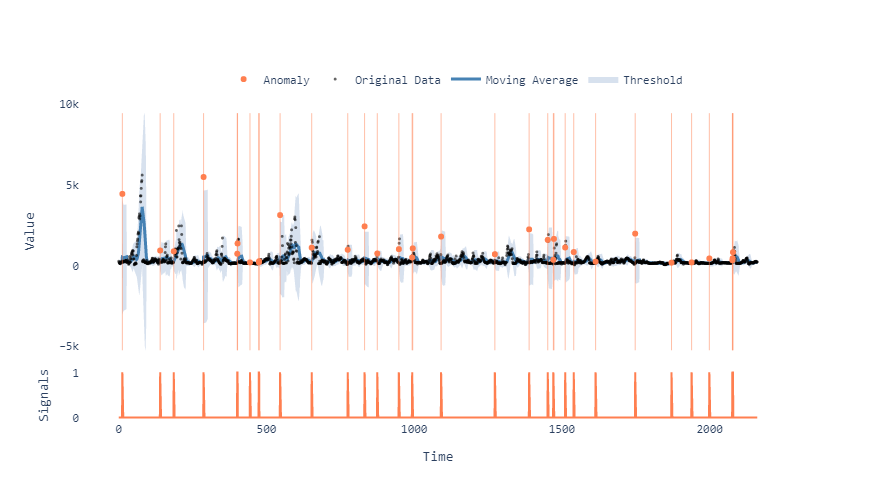

In [77]:
anomDetector.interactive_plot(p_df, "value")

And now with **MatPlotLib**

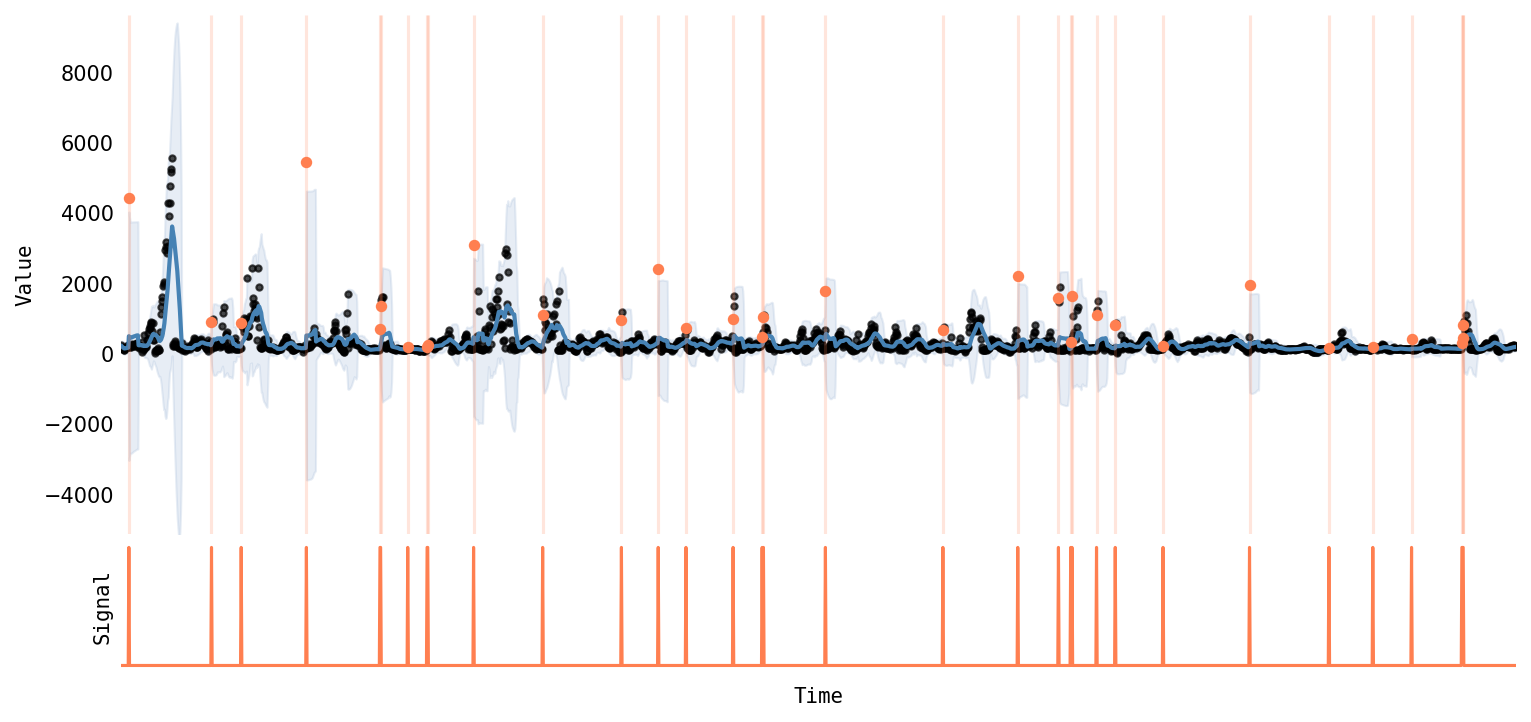

In [26]:
fig = PolarsAnomalyDetector(config).plot(p_df, "value")